# Sektion 2 - Single Vehicle Routing

## modified from:
## https://github.com/PlanQK/Routing/blob/master/Routing%20in%20directed%20graph.ipynb

# Routing in a directed graph
Consider a directed graph with edges $i=0, ..., N$ and edge costs $C_i$. We want to find a path from a start vertex to a target vertex. Let $X_i\in\{0,1\}$ be binary variables indicating if edge $i$ is chosen along the path.

The cost function is based on the following requirements:
- The start vertex has exactly one outgoing edge.
- The start vertex has no incoming edge.
- The target vertex has exactly one incoming edge.
- The target vertex has no outgoing edge.
- Every other vertex has
    - either one or zero incoming edges.
    - either one or zero outgoing edges.
    - an equal number of incoming and outgoing edges.


## Problem definition

In [1]:
## Cost function specification in sympy

import sympy as sym
import pandas as pd

# number of edges (Qubits)
N = sym.symbols('N')

# possible edges X_0, ..., X_{N-1} with values in {0,1}
X = sym.IndexedBase('X')

# costs for edges
C = sym.IndexedBase('C')

# penalty
P = sym.symbols('P')

# indices
i, j, k, v = sym.symbols('i j k v')

# start vertex: incoming and outgoing edges
VsI = sym.IndexedBase('VsI')    # incoming edges
LenVsI = sym.symbols('LenVsI')  # number of incoming edges
VsO = sym.IndexedBase('VsO')    # outgoing edges
LenVsO = sym.symbols('LenVsO')  # number of incoming edges

# target vertex: incoming and outgoing edges
VtI = sym.IndexedBase('VtI')    # incoming edges
LenVtI = sym.symbols('LenVtI')  # number of incoming edges
VtO = sym.IndexedBase('Vt O')   # outgoing edges
LenVtO = sym.symbols('LenVtO')  # number of incoming edges

# middle vertices: incoming and outgoing edges
# two indices: VI_(i,k) is the kth incoming edge at vertex i
# Similarly, LenVI_i is the number of incoming edges at vertex i
# the number of lists in LenVI and LenVO is the number of central vertices and must equal
LenV = sym.IndexedBase('LenV')   # number central vertices

VI = sym.IndexedBase('VI')        # incoming edges
LenVI = sym.IndexedBase('LenVI')  # number of incoming edges
VO = sym.IndexedBase('VO')        # outgoing edges
LenVO = sym.IndexedBase('LenVO')  # number of outgoing edges

cost_function = (
    sym.Sum( C[i] * X[i] , (i,0,N-1) ) +                    # costs for edge i
    P * (sym.Sum( X[VsO[i]], (i, 0, LenVsO-1) ) - 1 )**2 +  # exactly one outgoing edge at start vertex
    P * sym.Sum( X[VsI[i]], (i, 0, LenVsI-1) ) +            # no incoming edge at start vertex
    P * (sym.Sum( X[VtI[i]], (i, 0, LenVtI-1) ) - 1 )**2 +  # exactly one incoming edge at target vertex
    P * sym.Sum( X[VtO[i]], (i, 0, LenVtO-1) ) +            # no incoming edge at target vertex
    P * sym.Sum(                                            # one or zero incoming edges at each central point
        sym.Sum(  X[VI[v,i]] , (i, 0, LenVI[v]-1) ) *
        (sym.Sum(  X[VI[v,i]] , (i, 0, LenVI[v]-1) ) -1) ,
        (v, 0, LenV-1) ) +
    P * sym.Sum(                                            # one or zero outgoing edges at each central point
        sym.Sum(  X[VO[v,i]] , (i, 0, LenVO[v]-1) ) *
        (sym.Sum(  X[VO[v,i]] , (i, 0, LenVO[v]-1) ) -1) ,
        (v, 0, LenV-1) ) +
    P * sym.Sum(                                            # equal number of incoming and outgoing edges at each central point
        (sym.Sum(  X[VI[v,i]] , (i, 0, LenVI[v]-1) ) -
        sym.Sum(  X[VO[v,i]] , (i, 0, LenVO[v]-1) ))**2 ,
        (v, 0, LenV-1) ) )
cost_function

P*(Sum(X[VsO[i]], (i, 0, LenVsO - 1)) - 1)**2 + P*(Sum(X[VtI[i]], (i, 0, LenVtI - 1)) - 1)**2 + P*Sum((Sum(X[VI[v, i]], (i, 0, LenVI[v] - 1)) - 1)*Sum(X[VI[v, i]], (i, 0, LenVI[v] - 1)), (v, 0, LenV - 1)) + P*Sum((Sum(X[VO[v, i]], (i, 0, LenVO[v] - 1)) - 1)*Sum(X[VO[v, i]], (i, 0, LenVO[v] - 1)), (v, 0, LenV - 1)) + P*Sum((Sum(X[VI[v, i]], (i, 0, LenVI[v] - 1)) - Sum(X[VO[v, i]], (i, 0, LenVO[v] - 1)))**2, (v, 0, LenV - 1)) + P*Sum(X[VsI[i]], (i, 0, LenVsI - 1)) + P*Sum(X[Vt O[i]], (i, 0, LenVtO - 1)) + Sum(C[i]*X[i], (i, 0, N - 1))

## Data input

In [2]:
## graph structure
## external input

TestN = 5                   # number of edges
TestVsI = []                # indices of incoming edges at start vertex
TestVsO = [0,1]             # indices of outgoing edges at start vertex
TestVtI = [3,4]             # indices of incoming edges at target vertex
TestVtO = []                # indices of outgoing edges at target vertex
TestVI = [[0],[1,2]]        # indices of incoming edges at central vertices
TestVO = [[2,3],[4]]        # indices of outgoing edges at central vertices

## edge costs
## external input

TestC = [2,4,1,7,3]
TestP = 50

In [3]:
# diese Zelle einfach über die andere setzen, wenn mit dem kleineren graph getestet werden soll.
# die untere zelle ist die, die verwendet wird.

# dieser Graph ist als Bild unter graph-G1.png zu sehen

TestN = 17                  # number of edges
TestVsI = []                # indices of incoming edges at start vertex
TestVsO = [0,1,2,3]         # indices of outgoing edges at start vertex
TestVtI = [7,11,14,15]      # indices of incoming edges at target vertex
TestVtO = [16]                # indices of outgoing edges at target vertex
TestVI = [[0,12],[1,8],[2],[5,9],[3],[4,6],[10],[13,16]]        # indices of incoming edges at central vertices
TestVO = [[4],[5,6,7],[8,9],[10,11],[12],[13,14],[15],[]]        # indices of outgoing edges at central vertices

## edge costs
#        0 1 2 3  4  5 6 7  8 9 10 11 12 13 14 15 16
TestC = [6,4,1,2, 1, 3,2,5, 2,4, 4,2, 5, 3,3, 3, 4]
TestP = 50

## Data processing

In [4]:
## translation of graph structure into dictionaries for sympy

single_valued_dict = {
    N: TestN,
    P: TestP,
    LenVsI: len(TestVsI),
    LenVsO: len(TestVsO),
    LenVtI: len(TestVtI),
    LenVtO: len(TestVtO),
    LenV:  len(TestVI)
}

# multi-valued dictionaries
dict_VsI = { VsI[k]: TestVsI[k] for k in range(len(TestVsI)) }

dict_VsO = { VsO[k]: TestVsO[k] for k in range(len(TestVsO)) }

dict_VtI = { VtI[k]: TestVtI[k] for k in range(len(TestVtI)) }

dict_VtO = { VtO[k]: TestVtO[k] for k in range(len(TestVtO)) }

dict_LenVI = { LenVI[k]: len(TestVI[k]) for k in range(len(TestVI)) }

dict_LenVO = { LenVO[k]: len(TestVO[k]) for k in range(len(TestVO)) }

dict_VI = { VI[k, i]: TestVI[k][i] for k in range(len(TestVI)) for i in range(len(TestVI[k])) }

dict_VO = { VO[k, i]: TestVO[k][i] for k in range(len(TestVO)) for i in range(len(TestVO[k])) }

num_qubits = TestN

dict_costs = { C[k]: TestC[k] for k in range(len(TestC)) }


# definition of cost polynomial
cost_poly = sym.Poly(cost_function
                     .subs(single_valued_dict)
                     .doit()
                     .subs(dict_VsI)
                     .subs(dict_VsO)
                     .subs(dict_VtI)
                     .subs(dict_VtO)
                     .subs(dict_LenVI)
                     .subs(dict_LenVO)
                     .doit()
                     .subs(dict_VI)
                     .subs(dict_VO)
                     .subs(dict_costs)
                     ,
                     [X[i] for i in range(num_qubits)])

# um den funktionswert eines bestimmten ergebnisses zu testen, einfach für r einsetzen
# und die nächsten drei zeilen ausführen (ent-kommentieren)

#r = [1, 0, 1, 0, 1]
#X_dict = { X[i]: r[i] for i in range(len(r))}
#cost_function.subs(single_valued_dict).doit().subs(dict_VsI).subs(dict_VsO).subs(dict_VtI).subs(dict_VtO).subs(dict_LenVI).subs(dict_LenVO).doit().subs(dict_VI).subs(dict_VO).subs(dict_costs).subs(X_dict)

cost_poly

Poly(150*X[0]**2 + 100*X[0]*X[1] + 100*X[0]*X[2] + 100*X[0]*X[3] - 100*X[0]*X[4] + 200*X[0]*X[12] - 144*X[0] + 150*X[1]**2 + 100*X[1]*X[2] + 100*X[1]*X[3] - 100*X[1]*X[5] - 100*X[1]*X[6] - 100*X[1]*X[7] + 200*X[1]*X[8] - 146*X[1] + 150*X[2]**2 + 100*X[2]*X[3] - 100*X[2]*X[8] - 100*X[2]*X[9] - 149*X[2] + 150*X[3]**2 - 100*X[3]*X[12] - 148*X[3] + 200*X[4]**2 + 200*X[4]*X[6] - 100*X[4]*X[12] - 100*X[4]*X[13] - 100*X[4]*X[14] - 99*X[4] + 200*X[5]**2 + 200*X[5]*X[6] + 200*X[5]*X[7] - 100*X[5]*X[8] + 200*X[5]*X[9] - 100*X[5]*X[10] - 100*X[5]*X[11] - 97*X[5] + 200*X[6]**2 + 200*X[6]*X[7] - 100*X[6]*X[8] - 100*X[6]*X[13] - 100*X[6]*X[14] - 98*X[6] + 150*X[7]**2 - 100*X[7]*X[8] + 100*X[7]*X[11] + 100*X[7]*X[14] + 100*X[7]*X[15] - 145*X[7] + 200*X[8]**2 + 200*X[8]*X[9] - 98*X[8] + 200*X[9]**2 - 100*X[9]*X[10] - 100*X[9]*X[11] - 96*X[9] + 200*X[10]**2 + 200*X[10]*X[11] - 100*X[10]*X[15] - 96*X[10] + 150*X[11]**2 + 100*X[11]*X[14] + 100*X[11]*X[15] - 148*X[11] + 200*X[12]**2 - 95*X[12] + 200*X[13]

## QAOA

In [5]:
import qiskit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.test.mock import *
from qiskit.providers.aer import AerSimulator

# generate qiskit's cost function
qiskit_cost_function = QuadraticProgram()

# define qiskit variables
for i in range(num_qubits):
    qiskit_cost_function.binary_var('X_' + str(i))

# specify qiskit cost function
qiskit_cost_function.minimize(
    linear = [int(cost_poly.coeff_monomial(X[i]**1)) for i in range(num_qubits)],
    quadratic = {
        ('X_'+str(i), 'X_'+str(j)): cost_poly.coeff_monomial(X[i]**1 * X[j]**1)
        for i in range(num_qubits)
        for j in range(i,num_qubits)
    })

print(qiskit_cost_function.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 144 X_0 - 146 X_1 - 149 X_2 - 148 X_3 - 99 X_4 - 97 X_5 - 98 X_6
      - 145 X_7 - 98 X_8 - 96 X_9 - 96 X_10 - 148 X_11 - 95 X_12 - 97 X_13
      - 147 X_14 - 147 X_15 + 4 X_16 + [ 300 X_0^2 + 200 X_0*X_1 + 200 X_0*X_2
      + 200 X_0*X_3 - 200 X_0*X_4 + 400 X_0*X_12 + 300 X_1^2 + 200 X_1*X_2
      + 200 X_1*X_3 - 200 X_1*X_5 - 200 X_1*X_6 - 200 X_1*X_7 + 400 X_1*X_8
      + 300 X_2^2 + 200 X_2*X_3 - 200 X_2*X_8 - 200 X_2*X_9 + 300 X_3^2
      - 200 X_3*X_12 + 400 X_4^2 + 400 X_4*X_6 - 200 X_4*X_12 - 200 X_4*X_13
      - 200 X_4*X_14 + 400 X_5^2 + 400 X_5*X_6 + 400 X_5*X_7 - 200 X_5*X_8
      + 400 X_5*X_9 - 200 X_5*X_10 - 200 X_5*X_11 + 400 X_6^2 + 400 X_6*X_7
      - 200 X_6*X_8 - 200 X_6*X_13 - 200 X_6*X_14 + 300 X_7^2 - 200 X_7*X_8
      + 200 X_7*X_11 + 200 X_7*X_14 + 200 X_7*X_15 + 400 X_8^2 + 400 X_8*X_9
      + 400 X_9^2 - 200 X_9*X_10 - 200 X_9*X_11 + 400 X_10^2 + 400 X_10*X_

In [6]:
qaoa = QAOA(reps=1,quantum_instance =
             QuantumInstance(backend=qiskit.Aer.get_backend('qasm_simulator')))
optimizer_qaoa = MinimumEigenOptimizer(qaoa)

results = []

for i in range(10):
    result_qaoa = optimizer_qaoa.solve(qiskit_cost_function)
    results.append(result_qaoa)

## Results

In [7]:
qubit_results = []
for result in results:
    qubit_string = str(result.x).replace(' ', '').replace('.', '')[1:-1]
    qubit_results.append(qubit_string)


No handles with labels found to put in legend.


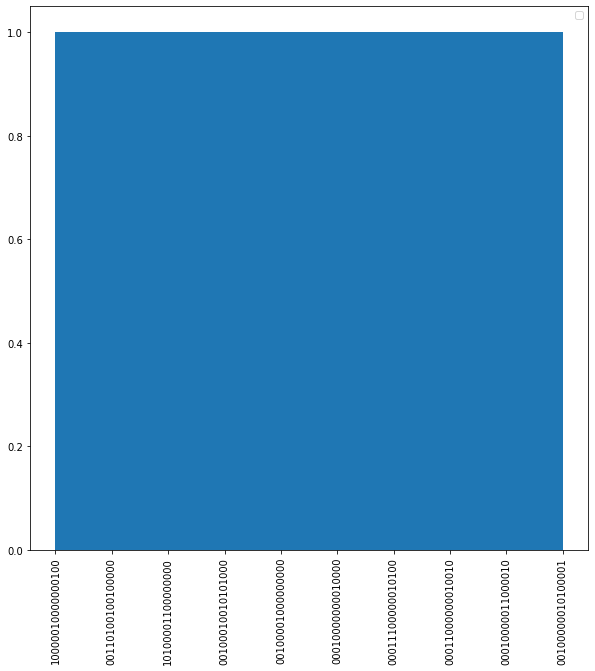

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.hist(qubit_results, bins = len(qubit_results))
plt.xticks(rotation='vertical')

plt.legend(loc='upper right')
plt.show()

In [9]:
qubit_results.count('00100000010100000')

0

In [10]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, CplexOptimizer

optimizer = CplexOptimizer() if CplexOptimizer.is_cplex_installed() else None

results_classic = []

for i in range(10):
    result = optimizer.solve(qiskit_cost_function)
    results_classic.append(result)

In [16]:
# path cost: Wegkosten
# actual_opt_cost: Optimierungskosten. Schließt Wegkosten und Penalty-Terms ein. Ist immer positiv.
# path: qubit-ergebnis
result_df_classic = pd.DataFrame(columns = ['path_cost', 'actual_opt_cost', 'path'])

for r in results_classic:
    
    path_cost = 0
    for q in range(len(r.x)):
        if r.x[q] == 1:
            path_cost += TestC[q]
    path_string = str(r.x).replace(' ', '').replace('.', '')[1:-1]

    result_df_classic = result_df_classic.append({'path_cost': path_cost, 'actual_opt_cost': r.fval + 2 * TestP, 'path': path_string}, ignore_index=True)

print("Cplex-Optimizer:")
print(result_df_classic.sort_values(by=['actual_opt_cost']))

Cplex-Optimizer:
  path_cost  actual_opt_cost               path
0         7              7.0  00100000010100000
1         7              7.0  00100000010100000
2         7              7.0  00100000010100000
3         7              7.0  00100000010100000
4         7              7.0  00100000010100000
5         7              7.0  00100000010100000
6         7              7.0  00100000010100000
7         7              7.0  00100000010100000
8         7              7.0  00100000010100000
9         7              7.0  00100000010100000


In [17]:

result_df = pd.DataFrame(columns = ['path_cost', 'actual_opt_cost', 'path'])

for r in results:
    
    path_cost = 0
    for q in range(len(r.x)):
        if r.x[q] == 1:
            path_cost += TestC[q]
    path_string = str(r.x).replace(' ', '').replace('.', '')[1:-1]

    result_df = result_df.append({'path_cost': path_cost, 'actual_opt_cost': r.fval + 2 * TestP, 'path': path_string}, ignore_index=True)

print("QAOA:")
print(result_df.sort_values(by=['actual_opt_cost']))

QAOA:
  path_cost  actual_opt_cost               path
4         6            106.0  00100001000000000
5         7            107.0  00010000000010000
1        10            110.0  00110100100100000
0        11            111.0  10000010000000100
7        11            111.0  00011000000010010
9        11            111.0  00100000010100001
3        12            112.0  00100010010101000
8        13            113.0  00010000011000010
2        14            114.0  10100001100000000
6        14            114.0  00011100000010100


In [14]:
# the mean optimization cost of the qaoa results
print((result_df['actual_opt_cost']).mean())

110.9
